#  天池新人实战赛o2o优惠券使用预测

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 读取数据
df_offline = pd.read_csv("./data/ccf_offline_stage1_train.csv")
#df_online = pd.read_csv("./data/ccf_online_stage1_train.csv")
df_test = pd.read_csv("./data/ccf_offline_stage1_test_revised.csv")

In [3]:
# offline 文件
df_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


    User_id        用户id

    Merchant_id     商家id

    Coupon_id	    优惠券id

    Discount_rate	  满x减y

    Distance	    x*500米,user常活动的地点与店铺距离，0：小于500米，10：大于5公里 

    Date_received  	领劵日期

    Date          消费日期

* 可能用的到的特征是“Discount_rate”“Distance”* 


In [4]:
# 去掉缺失值22-
df_offline_drop_miss = df_offline[["Discount_rate", "Distance"]].dropna()
#df_offline_drop_miss = df_offline.dropna()

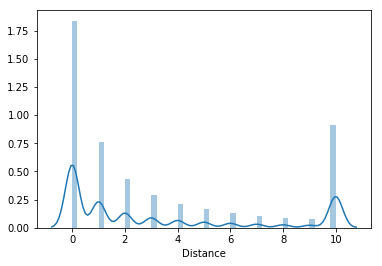

In [5]:
#histogram
sns.distplot(df_offline_drop_miss['Distance'])
#

## 处理标签

"Date" 就是我们要预测的结果，但不是预测日期，而是有没有使用。
 不同情况打上不同标签：
 收到优惠卷，未消费： -1
 未收到优惠卷，15天内消费： 0
 收到优惠卷， 消费：  1

In [ ]:
# 合并train 和test，同时做处理
data = pd.concat([df_offline, df_test], keys=(["train", "test"]))

#data["Date"] = pd.to_datetime(date["Date"],format="%Y%m%d")
#data["Date_received"] = pd.to_datetime(date["Date_received"],format="%Y%m%d")

def makeLabel(row):
    if row["Date_received"] == "null" and row["Date"] != "null":
        return 0
    elif row["Date_received"] != "null" and row["Date"] != "null":
        res = pd.to_datetime(row["Date"],format="%Y%m%d") - pd.to_datetime(row["Date_received"],format="%Y%m%d")
        if res < pd.Timedelta(15,"D"):
            return 1
    return -1

data["label"] = data[:].apply(makeLabel, axis=1)
data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## 特征

### 1. 折扣率

-  "Discount_rate"   满x减y
-  用折扣率 1-y/x代替

In [ ]:
## 特征1: 折扣率

def rate(x):
    x = str(x)
    length = len(x)
    a=1
    b=1
    if length == 3:
        return 1.0
    elif ":" in x:
        a,b = x.split(":")
        return 1-float(b)/float(a)
    else:
        return x

data["f_discount_rate"] = data["Discount_rate"].apply(lambda x : rate(x))



### 2. 折扣类型

-  1 满减
-  2 折扣率
-  3 无折扣

* 然后  ont-hot 编码*

In [ ]:
def discount_cls(x):
    x = str(x)
    length = len(x)
    if length == 3:
        return 3
    elif ":" in x:
        return 1
    else:
        return 2

data["f_discount_cls"] = data["Discount_rate"].copy()
data["f_discount_cls"] = data["f_discount_cls"].apply(lambda x : discount_cls(x))

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

In [ ]:
# 拆开数据
train_data=data.xs('train')
test_data=data.xs('test').drop(labels='Date',axis=1)

x_train = train_data.drop(labels="Date",axis=1).fillna(5.0)
y_train = train_data["Date"]
x_test = test_data.fillna(0)
x_train

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

S=StandardScaler()
S.fit(x_train)
x_train_stand=S.transform(x_train)
x_test_stand=S.transform(x_test)
Log=LogisticRegression(C=10)
Log.fit(x_train_stand,y_train)  #训练模型
prediction=Log.predict_proba(x_test_stand)  #用训练的模型Log来预测测试数据

print(prediction[:,0])
result=pd.DataFrame({'PassengerId':test_data.index,'Survived':prediction[:,0]})  #这里需要注意把prediction的数据转换成Int型不然系统判定不了，得分会为0 
result.to_csv('.\\result.csv',index=False) #设置不输出Index

In [ ]:

dftest1 = df_test[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = prediction[:,1]
dftest1.to_csv('submit1.csv', index=False, header=False)
dftest1.head()

## 划分正负样本

In [ ]:
# group = df_offline.groupby("Date")
# N_data = group.get_group(0)
# P_data = group.get_group(1)
# print("P : N = %d : %d " %(len(N_data), len(P_data)))

## 处理异常值

In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
df_offline = imputer.fit(df_offline.transform(df_offline))

## 特征间相关性分析

In [ ]:
# corrmat = P_data[["Discount_rate","Distance","Date"]].corr()
# f, ax = plt.subplots(figsize=(20, 9))
# sns.heatmap(corrmat, vmax=0.8, square=True)
